# Toxic Discourse and Parasocial Relationships in VTuber Communities

### Data retrieval through Reddit API

On how to use reddit API developer: 
Reddit. (n.d.). OAuth2 documentation https://www.reddit.com/dev/api/
Retrieved from https://github.com/reddit-archive/reddit/wiki/oauth2
https://github.com/praw-dev/praw

In [ ]:
import praw
import pandas as pd
import time

#Reddit API
reddit = praw.Reddit(
    client_id="put your reddit api id here",
    client_secret="put your reddit api password here",
    user_agent="ScrapingApp by u/ your reddit username here",
)

#subreddits
subreddits = [
    "kurosanji" #replace with the subreddit from list below
]

#"Hololive", "vtubers", "VirtualYoutuber", "okbuddyhololive", "Holostars",
    #"VShojo", "PhaseConnect", "Vspo", "kurosanji"
    #these subreddits were used for their relevance to the vtuber community

comments = []

#loop going through each subreddit
for sub in subreddits:
    print(f"collecting comments from r/{sub}...")
    subreddit = reddit.subreddit(sub)

    count = 0 #to count the amount of valid comments collected
    
    #retreiving each comments data
    for comment in subreddit.comments(limit=None): 
        if comment.body not in ("[removed]", "[deleted]") and comment.body.strip():
            comments.append({
                "subreddit": sub,
                "comment_id": comment.id,
                "body": comment.body,
                "score": comment.score,
                "created_utc": comment.created_utc,
                "parent_id": comment.parent_id,
                "link_id": comment.link_id
            })
            count += 1
    
        if count >= 1000:
            break
    print(f"saved {count} comments from r/{sub}") #print to check progress
    time.sleep(5)  #delay between subreddits

#save to CSV
df = pd.DataFrame(comments)
df.to_csv("kurosanji.csv", index=False)
print("success")


collecting comments from r/kurosanji...
Saved 958 comments from r/kurosanji
success


In [ ]:
#combining each collected subreddits data
import pandas as pd
import os

CSVfiles = {
    "Hololive": "hololive.csv",
    "vtubers": "vtubers.csv",
    "VirtualYoutuber": "VirtualYoutuber.csv",
    "okbuddyhololive": "okbuddyhololive.csv",
    "Holostars": "Holostars.csv",
    "VShojo": "VShojo.csv",
    "PhaseConnect": "PhaseConnect.csv",
    "Vspo": "Vspo.csv",
    "kurosanji": "kurosanji.csv"
}

dfs = []

for subreddit, filename in CSVfiles.items():
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        df["subreddit"] = subreddit #adding a column to know which subreddit data is connected to
        dfs.append(df)
    else:
        print(f"file not found {filename}")

combinedDf = pd.concat(dfs, ignore_index=True)

combinedDf.to_csv("datasetcombined.csv", index=False)

print("great success")

great success


### Data cleaning
https://docs.python.org/3/library/re.html 

In [2]:
import pandas as pd

df = pd.read_csv("datasetcombined.csv")
print(df.head())
print(df.columns)
print(df['subreddit'].value_counts())

  subreddit comment_id                                               body  \
0  Hololive    n671xrg  Counter-point: YOU think you have seen the ful...   
1  Hololive    n671m26  The little gasp she does as Ollie pops on scre...   
2  Hololive    n671f5q  You consider meat made from powder food. Maybe...   
3  Hololive    n671d5m  I agree - most people won't use it correctly a...   
4  Hololive    n67180h  most people using image generators and posting...   

   score   created_utc   parent_id     link_id  
0      1  1.753981e+09  t1_n666lyb  t3_1me0icx  
1      2  1.753981e+09  t3_1me094g  t3_1me094g  
2      1  1.753981e+09  t1_n66xzot  t3_1me0icx  
3      1  1.753981e+09  t1_n668jty  t3_1me0icx  
4      1  1.753981e+09  t1_n6709rq  t3_1me0icx  
Index(['subreddit', 'comment_id', 'body', 'score', 'created_utc', 'parent_id',
       'link_id'],
      dtype='object')
subreddit
okbuddyhololive    999
Holostars          994
Vspo               992
VirtualYoutuber    988
PhaseConnect       98

In [ ]:
import pandas as pd
import re
import unicodedata
import csv

def cleanText(text):
    text = str(text)
    text = text.replace('\n', ' ').replace('\r', ' ') #remove line breaks
    text = unicodedata.normalize("NFKD", text)  #normalise Unicode
    text = text.encode("ascii", "ignore").decode("ascii")  #remove non-ASCII
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  #remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  #remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text)  #normalise whitespace
    return text.strip()

#replace with space
df['body'] = df['body'].astype(str).str.replace('\n', ' ').str.replace('\r', ' ')


#export to CSV with proper encoding and quoting
df.to_csv("cleanedOutput.csv", index=False, quoting=csv.QUOTE_ALL, encoding="utf-8-sig")


In [ ]:
def clean_for_perspective(text):
    text = str(text)
    text = text.replace('\n', ' ').replace('\r', ' ')  #flatten multiline
    text = re.sub(r'http\S+', '', text)  #remove URLs
    text = re.sub(r'\s+', ' ', text)  #normalise spaces
    return text.strip()

#replace with space
df['body'] = df['body'].astype(str).str.replace('\n', ' ').str.replace('\r', ' ')

df.to_csv("OutputforPerspective.csv", index=False, quoting=csv.QUOTE_ALL, encoding="utf-8-sig")


### Toxicity Scoring with Perspective API
https://www.perspectiveapi.com/
https://github.com/conversationai/perspectiveapi

In [ ]:
import pandas as pd
import requests
import json
import time
import csv
import os

API_KEY = "API KEY HERE - get from google cloud"
url = f"https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={API_KEY}"

INPUT = "OutputforPerspective.csv"
OUTPUT = "perspectivescored.csv"


ATTRIBUTES = [
    "TOXICITY",
    "SEVERE_TOXICITY",
    "INSULT",
    "PROFANITY",
    "THREAT",
    "IDENTITY_ATTACK",
    "FLIRTATION",
    "SEXUALLY_EXPLICIT",
]

#function to analyse comment, send text to perspective api and get attribute scores
#using try and except as documentation example was not working 
def scoringText(text, attributes):
    data = {
        "comment": {"text": text},
        "languages": ["en"],
        "requestedAttributes": {},
    }
    for attr in attributes:
        data["requestedAttributes"][attr] = {}

    try:
        response = requests.post(url, data=json.dumps(data))

        if response.status_code != 200:
            print(f"API Error ({response.status_code}): {response.text}")
            scores = {}
            for attr in attributes:
                scores[attr] = None
            return scores

        result = response.json()

        scores = {}
        for attr in attributes:
            value = result.get("attributeScores", {}).get(attr, {}).get("summaryScore", {}).get("value", None)
            scores[attr] = value

        return scores

    except Exception as e:
        print("Request failed:", e)
        scores = {}
        for attr in attributes:
            scores[attr] = None
        return scores



df = pd.read_csv(INPUT, encoding="utf-8-sig")

#checking data columns
if "cleaned_body" not in df.columns:
    raise ValueError("Missing 'cleaned_body' column in input CSV.")

#create output csv with header if it doesnt exist
if not os.path.exists(OUTPUT):
    with open(OUTPUT, mode="w", newline="", encoding="utf-8-sig") as f_out:
        fieldnames = list(df.columns)

        #add attribute score columns in lowercase
        for attr in ATTRIBUTES:
            fieldnames.append(attr.lower())

        writer = csv.DictWriter(f_out, fieldnames=fieldnames, quoting=csv.QUOTE_ALL)
        writer.writeheader()

#track already processed comment IDs
processed_ids = set()
if os.path.exists(OUTPUT):
    out_df = pd.read_csv(OUTPUT, encoding="utf-8-sig")
    if "comment_id" in out_df.columns:
        processed_ids = set(out_df["comment_id"])

#append mode writing
with open(OUTPUT, mode="a", newline="", encoding="utf-8-sig") as f_out:
    writer = None
    for i, row in df.iterrows():
        if "comment_id" in row and row["comment_id"] in processed_ids:
            continue

        text = row["cleaned_body"]

        if not isinstance(text, str) or not text.strip():
            scores = {}
            for attr in ATTRIBUTES:
                scores[attr] = None

        else:
            scores = scoringText(text, ATTRIBUTES)
            time.sleep(1.2)  #delay for rate limit
        
        row_data = row.to_dict()
        for attr in ATTRIBUTES:
            row_data[attr.lower()] = scores[attr]

        if writer is None:
            writer = csv.DictWriter(f_out, fieldnames=row_data.keys(), quoting=csv.QUOTE_ALL)

        writer.writerow(row_data)
        f_out.flush()  #save progress

print("great success")


In [ ]:
##identify clean entries and check for rows containing stop words 
import pandas as pd
from nltk.corpus import stopwords

df = pd.read_csv("perscored.csv", encoding="utf-8-sig")

stopWords = set(stopwords.words('english'))

#check empty strings
emptyRows = df[df['cleaned_body'].fillna("").str.strip() == ""]
print(f"Empty cleaned_body rows {len(emptyRows)}")

#check only stopword rows
def STOPwords(text):
    if not isinstance(text, str):  #handles nan or non string values
        return False

    words = text.split()

    if not words:  #empty string
        return False

    for word in words:
        if word not in stopWords:
            return False

    return True

onlyStopwordRows = df[df['cleaned_body'].apply(STOPwords)]
print(f"rows with only stopwords {len(onlyStopwordRows)})")

Empty cleaned_body rows: 282
Rows with only stopwords: 60)


In [ ]:
#remove empty or only stopword rows
maskEmpty = df['cleaned_body'].fillna("").str.strip() == ""
maskOnlyStop = df['cleaned_body'].apply(STOPwords)

dfClean = df[~(maskEmpty | maskOnlyStop)]

print(f"rows after cleaning: {len(dfClean)}")

#save cleaned dataset
dfClean.to_csv("pclean.csv", index=False, encoding="utf-8-sig")
print("Saved csv")

Remaining rows after cleaning: 5187
Saved cleaned file as perscoredclean.csv


### Descriptive statistics

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#selecting Perspective attributes
attributes = [
    "toxicity",
    "severe_toxicity",
    "insult",
    "profanity",
    "threat",
    "identity_attack",
    "flirtation",
    "sexually_explicit"
]

#mean and standard deviation for each community
descStats = df.groupby("subreddit")[attributes].agg(['mean', 'std']).round(3)

print(descStats)

                toxicity        severe_toxicity        insult         \
                    mean    std            mean    std   mean    std   
subreddit                                                              
Hololive           0.143  0.159           0.012  0.042  0.063  0.106   
Holostars          0.149  0.155           0.014  0.041  0.061  0.099   
VShojo             0.159  0.172           0.016  0.049  0.072  0.117   
VirtualYoutuber    0.168  0.193           0.021  0.061  0.069  0.121   
okbuddyhololive    0.225  0.230           0.037  0.086  0.099  0.139   
vtubers            0.153  0.166           0.014  0.039  0.054  0.086   

                profanity        threat        identity_attack         \
                     mean    std   mean    std            mean    std   
subreddit                                                               
Hololive            0.090  0.143  0.019  0.052           0.022  0.039   
Holostars           0.090  0.133  0.032  0.075           0.

In [ ]:
descStats.to_csv("descriptiveStats.csv", encoding="utf-8-sig") #save desc to csv 

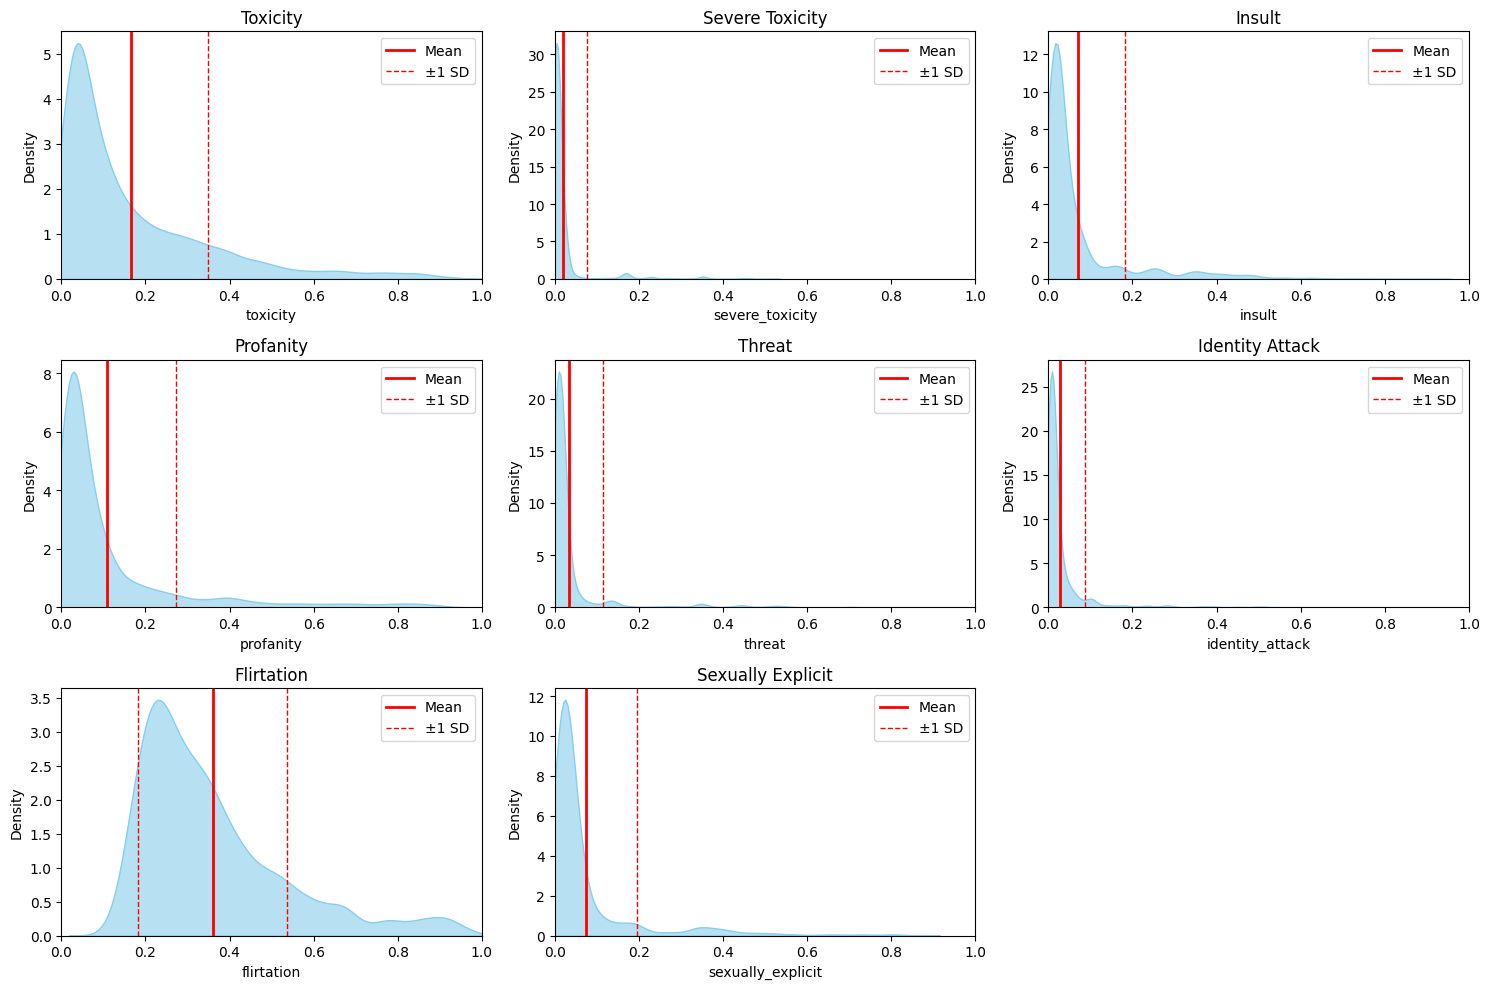

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#load dataset
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#perspective API attributes
attributes = [
    "toxicity",
    "severe_toxicity",
    "insult",
    "profanity",
    "threat",
    "identity_attack",
    "flirtation",
    "sexually_explicit"
]

#set up subplots grid
n_cols = 3
n_rows = (len(attributes) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

#plot density for each attribute
for i, attr in enumerate(attributes):
    #drop NaN just in case
    data = df[attr].dropna()

    #KDE plot
    sns.kdeplot(
        data=data,
        fill=True,
        ax=axes[i],
        color="skyblue",
        alpha=0.6
    )

    #calculate mean and SD
    mean_val = data.mean()
    sd_val = data.std()

    #plot mean line
    axes[i].axvline(mean_val, color="red", linestyle="-", linewidth=2, label="Mean")

    #plot ±1 SD lines
    axes[i].axvline(mean_val - sd_val, color="red", linestyle="--", linewidth=1, label="±1 SD")
    axes[i].axvline(mean_val + sd_val, color="red", linestyle="--", linewidth=1)

    axes[i].set_title(attr.replace("_", " ").title())
    axes[i].set_xlim(0, 1)
    axes[i].legend()

#hiding unused axes
for j in range(len(attributes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Statistical Analysis

In [83]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal
import pingouin as pg #for effect size


In [ ]:
#load CSV
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#attributes
attributes = [
    "toxicity",
    "severe_toxicity",
    "insult",
    "profanity",
    "threat",
    "identity_attack",
    "flirtation",
    "sexually_explicit"
]

#hololive vs holostars for gendered comparison using pairwise test
hololive = df[df["subreddit"].str.lower() == "hololive"]
holostars = df[df["subreddit"].str.lower() == "holostars"]

#make empty list for results
results = []

for attr in attributes:
    #drop NaNs
    holoScores = hololive[attr].dropna()
    starsScores = holostars[attr].dropna()

    normHolo = pg.normality(holoScores)["normal"].iloc[0]
    normStars = pg.normality(starsScores)["normal"].iloc[0]

    if normHolo and normStars:
        #independent t test
        stat, p = ttest_ind(holoScores, starsScores, equal_var=False)
        test_used = "t-test"
    else:
        #mann whitney U
        stat, p = mannwhitneyu(holoScores, starsScores, alternative="two-sided")
        test_used = "Mann–Whitney U"
    #effect size Cohens D
    d = pg.compute_effsize(holoScores, starsScores, eftype="cohen")

    results.append({attr, test_used, stat, p, d})
    results_df = pd.DataFrame(results)

print(results_df)

          0                  1             2                3                4
0  toxicity           0.115628 -3.847872e-02         440617.5   Mann–Whitney U
1 -0.034441           421098.5  1.456551e-03   Mann–Whitney U  severe_toxicity
2  0.270594           446337.0  2.506709e-02           insult   Mann–Whitney U
3  436843.0           0.059473  1.095272e-03        profanity   Mann–Whitney U
4 -0.203143             threat  2.713145e-15         363863.5   Mann–Whitney U
5 -0.148344           0.012079  4.292630e+05  identity_attack   Mann–Whitney U
6 -0.163298         flirtation  7.237555e-08   Mann–Whitney U         394398.0
7 -0.043966  sexually_explicit  4.300030e+05         0.014334   Mann–Whitney U


In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

results = []

for attr in attributes:
    holo_vals = hololive[attr].dropna()
    stars_vals = holostars[attr].dropna()

    #mann whitney U
    stat, p = mannwhitneyu(holo_vals, stars_vals, alternative="two-sided")

    #cohens d
    d = (np.mean(holo_vals) - np.mean(stars_vals)) / np.sqrt(
        (np.var(holo_vals, ddof=1) + np.var(stars_vals, ddof=1)) / 2
    )

    results.append({: attr, : np.mean(holo_vals), : np.mean(stars_vals), : p, : d })

#print full results
results_df = pd.DataFrame(results)
print(results_df)


           Attribute  Hololive Mean  Holostars Mean       p-value  \
0           toxicity       0.142681        0.148727  1.156278e-01   
1    severe_toxicity       0.012257        0.013680  1.456551e-03   
2             insult       0.063485        0.060913  2.705939e-01   
3          profanity       0.089993        0.089842  5.947297e-02   
4             threat       0.018886        0.032025  2.713145e-15   
5    identity_attack       0.021862        0.029478  1.207923e-02   
6         flirtation       0.348341        0.374180  7.237555e-08   
7  sexually_explicit       0.056316        0.060278  1.433373e-02   

   Effect Size (d)  
0        -0.038470  
1        -0.034438  
2         0.025054  
3         0.001095  
4        -0.203753  
5        -0.148892  
6        -0.163212  
7        -0.044001  


In [85]:
import pandas as pd
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

for attr in attributes:
    groups = [df[df["subreddit"] == sub][attr].dropna() for sub in df["subreddit"].unique()]
    k = len(groups)
    n = sum(len(g) for g in groups)

    #check normality of groups
    normality = [pg.normality(g)["normal"].iloc[0] for g in groups]
    
    if all(normality):
        #ANOVA
        stat, p = f_oneway(*groups)
        df_between = k - 1
        df_within = n - k
        test = "ANOVA"
        eta_sq = pg.anova(data=df, dv=attr, between="subreddit")["np2"].iloc[0]
    else:
        #kruskal wallis
        stat, p = kruskal(*groups)
        df_kw = k - 1
        test = "Kruskal-Wallis"
        eta_sq = (stat - k + 1) / (n - k) ##eta squared for KW

    print(f"{attr}: {test}, H({df_kw}, N{n}) = {stat:.3f}, p {p:.3e}, etasquare {eta_sq:.4f}")

toxicity: Kruskal-Wallis, H(5, N5187) = 49.032, p 2.186e-09, etasquare 0.0085
severe_toxicity: Kruskal-Wallis, H(5, N5187) = 63.838, p 1.952e-12, etasquare 0.0114
insult: Kruskal-Wallis, H(5, N5187) = 56.855, p 5.418e-11, etasquare 0.0100
profanity: Kruskal-Wallis, H(5, N5187) = 61.206, p 6.845e-12, etasquare 0.0108
threat: Kruskal-Wallis, H(5, N5187) = 105.076, p 4.493e-21, etasquare 0.0193
identity_attack: Kruskal-Wallis, H(5, N5187) = 114.088, p 5.599e-23, etasquare 0.0211
flirtation: Kruskal-Wallis, H(5, N5187) = 65.716, p 7.960e-13, etasquare 0.0117
sexually_explicit: Kruskal-Wallis, H(5, N5187) = 67.258, p 3.809e-13, etasquare 0.0120


### Sentiment Analysis
https://github.com/cjhutto/vaderSentiment
Using Vader specifically specialised for social media scoring 


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

#load datatset 
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#initialise vader
analyse = SentimentIntensityAnalyzer()

#sentiment for each comment
df["sentiment_score"] = df["cleaned_body"].astype(str).apply(
    lambda x: analyse.polarity_scores(x)["compound"]
)

#adding to csv 
df.to_csv("perscoredclean.csv", index=False, encoding="utf-8-sig")


In [ ]:
#correlation analysis
attributes = ["toxicity", "severe_toxicity", "insult", "profanity", 
              "threat", "identity_attack", "flirtation", "sexually_explicit"]

for attr in attributes:
    pearson_corr, pearson_p = pearsonr(df["sentiment_score"], df[attr])
    spearman_corr, spearman_p = spearmanr(df["sentiment_score"], df[attr])
    print(f"{attr} vs sentiment:")
    print(f" pearson r  {pearson_corr:.3f}, p = {pearson_p:.4g}")
    print(f" spearman rho  {spearman_corr:.3f}, p = {spearman_p:.4g}")
    print("-"*40)

toxicity vs sentiment:
  Pearson r = -0.265, p = 2.127e-84
  Spearman rho = -0.192, p = 3.311e-44
----------------------------------------
severe_toxicity vs sentiment:
  Pearson r = -0.217, p = 4.488e-56
  Spearman rho = -0.150, p = 2.223e-27
----------------------------------------
insult vs sentiment:
  Pearson r = -0.251, p = 3.066e-75
  Spearman rho = -0.183, p = 3.79e-40
----------------------------------------
profanity vs sentiment:
  Pearson r = -0.237, p = 2.026e-67
  Spearman rho = -0.153, p = 1.209e-28
----------------------------------------
threat vs sentiment:
  Pearson r = -0.140, p = 3.398e-24
  Spearman rho = -0.084, p = 1.533e-09
----------------------------------------
identity_attack vs sentiment:
  Pearson r = -0.092, p = 3.671e-11
  Spearman rho = -0.074, p = 9.077e-08
----------------------------------------
flirtation vs sentiment:
  Pearson r = 0.168, p = 5.613e-34
  Spearman rho = 0.172, p = 1.117e-35
----------------------------------------
sexually_explicit

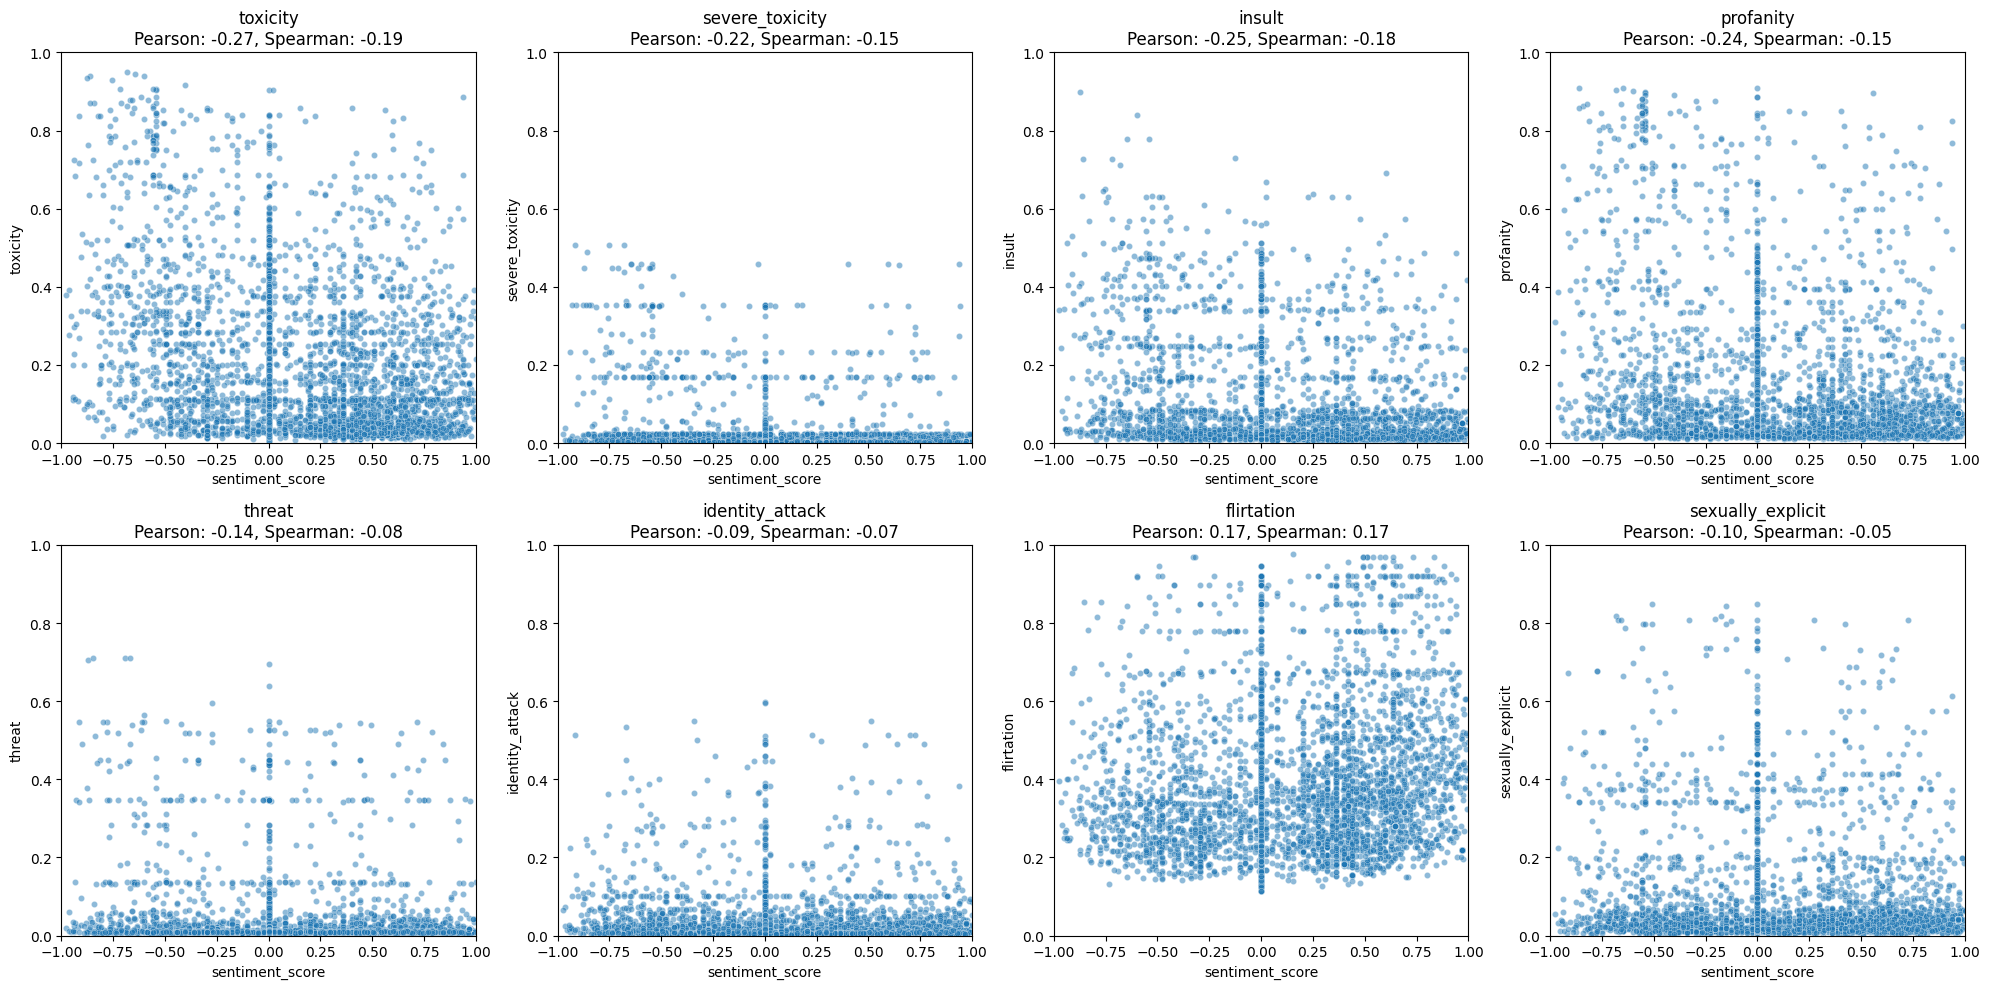

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# load dataset with sentiment
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

attributes = [
    "toxicity",
    "severe_toxicity",
    "insult",
    "profanity",
    "threat",
    "identity_attack",
    "flirtation",
    "sexually_explicit"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, attr in enumerate(attributes):
    ax = axes[i]
    
    #remove NANs just for correlation
    sub_df = df[["sentiment_score", attr]].dropna()
    
    #pearson and spearman correlations
    pearson_corr, _ = pearsonr(sub_df["sentiment_score"], sub_df[attr])
    spearman_corr, _ = spearmanr(sub_df["sentiment_score"], sub_df[attr])
    
    #scatter plot
    sns.scatterplot(
        data=sub_df,
        x="sentiment_score",
        y=attr,
        alpha=0.5,
        s=20,
        ax=ax
    )
    
    ax.set_xlim(-1, 1)  #VADER compound range
    ax.set_ylim(0, 1)   #perspective score range, note: can be changed depending on scores
    ax.set_title(f"{attr}\npearson {pearson_corr:.2f}, spearman {spearman_corr:.2f}")

plt.tight_layout()
plt.show()


### Linguistic feature analysis

In [ ]:
#TF-IDF 
#split dataset into high and low toxicity based on >0.5 threshold
#vecotrise text with tf-idf
#extract top weighted terms for each 

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
from nltk.corpus import stopwords

#convert stopwords to a list
stop_words = list(stopwords.words("english"))

#load CSV
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#define toxicity threshold
threshold = 0.5
df["toxicity_group"] = np.where(df["toxicity"] > threshold, "high", "low")

def get_top_tfidf_terms(corpus, n=20):
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.8, min_df=5)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    mean_scores = np.array(X.mean(axis=0)).flatten()
    top_indices = mean_scores.argsort()[::-1][:n]
    return [(feature_names[i], mean_scores[i]) for i in top_indices]

#high toxicity
high_terms = get_top_tfidf_terms(df[df["toxicity_group"] == "high"]["cleaned_body"].dropna())
low_terms = get_top_tfidf_terms(df[df["toxicity_group"] == "low"]["cleaned_body"].dropna())

print("\ntop high toxicity")
for term, score in high_terms:
    print(f"{term}: {score:.4f}")

print("\ntop low toxicity")
for term, score in low_terms:
    print(f"{term}: {score:.4f}")


Top terms in HIGH toxicity comments:
fuck: 0.0671
shit: 0.0546
fucking: 0.0485
like: 0.0444
im: 0.0392
damn: 0.0370
get: 0.0277
would: 0.0260
ass: 0.0238
dont: 0.0226
people: 0.0221
sex: 0.0215
one: 0.0214
holy: 0.0198
thats: 0.0196
think: 0.0194
even: 0.0190
well: 0.0179
cant: 0.0177
right: 0.0175

Top terms in LOW toxicity comments:
like: 0.0186
im: 0.0173
one: 0.0143
dont: 0.0140
would: 0.0114
get: 0.0107
know: 0.0098
thats: 0.0097
good: 0.0095
love: 0.0088
also: 0.0088
time: 0.0083
think: 0.0083
got: 0.0082
please: 0.0082
well: 0.0077
see: 0.0076
still: 0.0074
yes: 0.0074
even: 0.0074


### Latent Dirichlet Allocation (LDA)

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
https://github.com/piskvorky/gensim

In [89]:
#finding coherence scores
from gensim.models.coherencemodel import CoherenceModel

coherence_scores = []
for k in range(3, 11):  # test topic numbers 3–10
    lda = gensim.models.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=k,
        random_state=42, passes=10, alpha='auto'
    )
    coherence = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append((k, coherence.get_coherence()))

print(coherence_scores)

[(3, 0.3724359987711758), (4, 0.41602117765253693), (5, 0.3906442261048584), (6, 0.41593826926291205), (7, 0.4188292414251946), (8, 0.44676544550817054), (9, 0.4220573539366219), (10, 0.4314160988391088)]


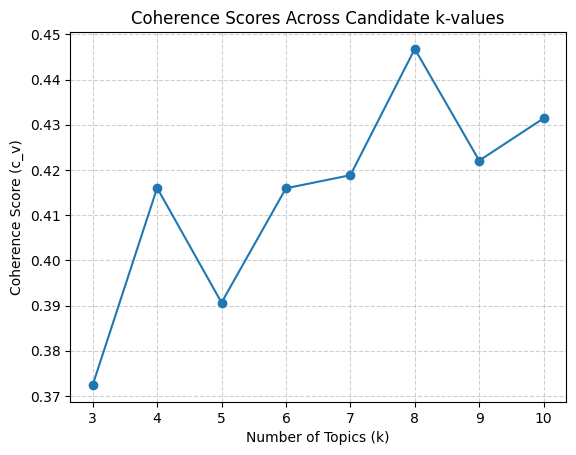

In [ ]:
import matplotlib.pyplot as plt

#unpack k values, coherence scores
k_values, scores = zip(*coherence_scores)

#plot
plt.plot(k_values, scores, marker='o')
plt.title("Coherence Scores Across Candidate k-values")
plt.xlabel("Number of Topics (k)")
plt.ylabel("Coherence Score (c_v)")
plt.xticks(k_values)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
import nltk
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize

#load csv
#df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#filter high toxicity
high_df = df[df["toxicity"] > threshold].dropna(subset=["cleaned_body"])

#tokenize and clean
texts = []

for comment in high_df["cleaned_body"]:
    if not isinstance(comment, str):
        continue  #skip nonstring entries
    
    #lowercase and tokenize
    words = word_tokenize(comment.lower())
    
    #keep only alphabetic words that are not stopwords
    cleaned_words = []
    for word in words:
        if word.isalpha() and word not in stop_words:
            cleaned_words.append(word)
    
    texts.append(cleaned_words)


#create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

#train LDA
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=8,   #used 8 based on coherence scores
    random_state=42,
    passes=10,
    alpha='auto'
)

#print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"topic {idx}:\n {topic}\n")


topic 0:
 0.012*"like" + 0.012*"would" + 0.010*"right" + 0.010*"think" + 0.007*"shit" + 0.006*"fucking" + 0.006*"ass" + 0.006*"fool" + 0.006*"stream" + 0.006*"mean"

topic 1:
 0.013*"fucking" + 0.010*"like" + 0.009*"well" + 0.007*"one" + 0.005*"mean" + 0.005*"people" + 0.005*"get" + 0.005*"alien" + 0.005*"dont" + 0.005*"love"

topic 2:
 0.012*"fuck" + 0.010*"fucking" + 0.010*"dont" + 0.009*"damn" + 0.008*"like" + 0.007*"get" + 0.006*"shit" + 0.006*"im" + 0.006*"thats" + 0.006*"youre"

topic 3:
 0.014*"big" + 0.014*"shit" + 0.010*"im" + 0.010*"one" + 0.008*"holy" + 0.008*"fuck" + 0.008*"mommy" + 0.008*"like" + 0.008*"shes" + 0.006*"ass"

topic 4:
 0.015*"fuck" + 0.009*"like" + 0.005*"think" + 0.005*"art" + 0.005*"fucking" + 0.005*"time" + 0.004*"cant" + 0.004*"make" + 0.004*"shit" + 0.004*"im"

topic 5:
 0.022*"shit" + 0.013*"im" + 0.013*"fuck" + 0.010*"ai" + 0.008*"damn" + 0.006*"like" + 0.006*"really" + 0.005*"going" + 0.005*"dont" + 0.005*"man"

topic 6:
 0.015*"fucking" + 0.008*"im"

In [91]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora

stop_words = set(stopwords.words('english'))

#high toxicity
high_df = df[df["toxicity"] > threshold].dropna(subset=["cleaned_body"])

high_texts = []

for comment in high_df["cleaned_body"]:
    if not isinstance(comment, str):
        continue  # skip non-string entries

    #lowercase and tokenize
    words = word_tokenize(comment.lower())

    #keep only alphabetic words that are not stopwords
    cleaned_words = []
    for word in words:
        if word.isalpha() and word not in stop_words:
            cleaned_words.append(word)

    high_texts.append(cleaned_words)

high_dictionary = corpora.Dictionary(high_texts)
high_corpus = [high_dictionary.doc2bow(text) for text in high_texts]

high_lda_model = gensim.models.LdaModel(
    corpus=high_corpus,
    id2word=high_dictionary,
    num_topics=8,
    random_state=42,
    passes=10,
    alpha='auto'
)

#low toxicity
low_df = df[df["toxicity"] <= threshold].dropna(subset=["cleaned_body"])
low_texts = []

for comment in low_df["cleaned_body"]:
    if not isinstance(comment, str):
        continue  #skip nonstring entries

    #lowercase and tokenize
    words = word_tokenize(comment.lower())

    #keep only alphabetic words that are not stopwords
    cleaned_words = []
    for word in words:
        if word.isalpha() and word not in stop_words:
            cleaned_words.append(word)

    low_texts.append(cleaned_words)

low_dictionary = corpora.Dictionary(low_texts)
low_corpus = [low_dictionary.doc2bow(text) for text in low_texts]

low_lda_model = gensim.models.LdaModel(
    corpus=low_corpus,
    id2word=low_dictionary,
    num_topics=8,
    random_state=42,
    passes=10,
    alpha='auto'
)

In [97]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.phrases import Phraser

#load CSV
df = pd.read_csv("perscoredclean.csv", encoding="utf-8-sig")

#thresholds have been chosen as a middle point
high_threshold = 0.7
low_threshold = 0.2

#stopwords and profanity list
stopWords = set(stopwords.words("english"))
profanityList = {"fuck", "shit", "fucking", "damn", "thats"}

def preprocess(sub_df):
    texts = [
        [
            word for word in word_tokenize(comment.lower())
            if word.isalpha()
            and word not in stopWords
            and word not in profanityList
        ]
        for comment in sub_df["cleaned_body"].dropna()
    ]
    
    #adding bigrams/trigrams
    bigram = Phrases(texts, min_count=5, threshold=10)
    trigram = Phrases(bigram[texts], threshold=10)
    
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    return texts

def run_lda(texts, num_topics=8):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto'
    )
    
    return lda_model

#separate datasets
high_df = df[df["toxicity"] > high_threshold]
low_df = df[df["toxicity"] < low_threshold]

#preprocess
high_texts = preprocess(high_df)
low_texts = preprocess(low_df)

#run LDA
high_lda = run_lda(high_texts, num_topics=8)
low_lda = run_lda(low_texts, num_topics=8)

#print topics
print("high toxicity topics")
for idx, topic in high_lda.print_topics(-1):
    print(f"Topic {idx}:\n {topic}\n")

print("low toxicity topics")
for idx, topic in low_lda.print_topics(-1):
    print(f"Topic {idx}:\n {topic}\n")


high toxicity topics
Topic 0:
 0.012*"bad" + 0.012*"horny" + 0.012*"make" + 0.012*"option" + 0.012*"say" + 0.006*"like" + 0.006*"lot" + 0.006*"ass" + 0.006*"guys" + 0.006*"come"

Topic 1:
 0.026*"mean" + 0.026*"mommy" + 0.022*"big" + 0.018*"tit" + 0.018*"milker" + 0.013*"right" + 0.013*"sorry" + 0.009*"ass" + 0.009*"said" + 0.009*"cute"

Topic 2:
 0.013*"hot" + 0.013*"think" + 0.013*"like" + 0.009*"ass" + 0.009*"im" + 0.009*"class" + 0.009*"talent" + 0.009*"might" + 0.009*"hate" + 0.005*"yet"

Topic 3:
 0.008*"like" + 0.008*"dont" + 0.008*"would" + 0.008*"fear" + 0.008*"type" + 0.008*"fauna" + 0.008*"give" + 0.008*"killed" + 0.008*"tho" + 0.008*"love"

Topic 4:
 0.013*"dnd" + 0.013*"like" + 0.009*"still" + 0.009*"well" + 0.009*"wait" + 0.009*"streaming" + 0.009*"system" + 0.009*"pretending" + 0.009*"shes" + 0.009*"ttrpg"

Topic 5:
 0.020*"ass" + 0.012*"put" + 0.012*"holy" + 0.012*"would" + 0.008*"like" + 0.008*"mean" + 0.008*"everything" + 0.008*"balls" + 0.008*"fat" + 0.008*"probably"

In [93]:
#create corpus from the dictionary used in LDA
high_dictionary = high_lda.id2word  # get the dictionary from the trained model
high_corpus = [high_dictionary.doc2bow(doc) for doc in high_texts]

#getting document topic distributions
doc_topics_high = [high_lda.get_document_topics(bow) for bow in high_corpus]


In [70]:
import numpy as np

dominant_topics = []
topic_weights = []

for doc in doc_topics_high:
    if len(doc) == 0:
        dominant_topics.append(None)
        topic_weights.append(0)
    else:
        topic_id, weight = max(doc, key=lambda x: x[1])
        dominant_topics.append(topic_id)
        topic_weights.append(weight)

high_df = high_df.reset_index(drop=True)
high_df['dominant_topic'] = dominant_topics
high_df['topic_weight'] = topic_weights


In [ ]:
#group by topic and take comment with max weight
representative_comments = high_df.groupby('dominant_topic').apply(
    lambda x: x.loc[x['topic_weight'].idxmax()]
).reset_index(drop=True)

#filtering to only get relevant columns
representative_comments = representative_comments[['dominant_topic', 'cleaned_body', 'topic_weight', 'toxicity']]
print(representative_comments)


   dominant_topic                                       cleaned_body  \
0               0  turbo fujo you guys should have gay sex with e...   
1               1  she isnt shes more like big tit mommy milker s...   
2               2  theres some dipshit on tiktok who went viral d...   
3               3  what the fuck do you mean demiromantic ii can ...   
4               4  there are some vtuber fans who just do not kno...   
5               5  the worst was really when she said some things...   
6               6  can confirm gym people are weird as shit im on...   
7               7  youre talking a lot of mad shit for someone wh...   

   topic_weight  toxicity  
0      0.972243  0.788558  
1      0.986259  0.736634  
2      0.980794  0.928801  
3      0.980936  0.885998  
4      0.992548  0.799855  
5      0.988124  0.725297  
6      0.974073  0.718943  
7      0.990414  0.829959  


/var/folders/p2/7_2jl99j7d57ttbhn9dx8x5c0000gn/T/ipykernel_69635/2193626875.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  representative_comments = high_df.groupby('dominant_topic').apply(


In [ ]:
#for low
low_dictionary = low_lda.id2word  # get the dictionary from the trained model
low_corpus = [low_dictionary.doc2bow(doc) for doc in low_texts]

dominant_topics = []
topic_weights = []


#getting document topic distributions
doc_topics_low = [low_lda.get_document_topics(bow) for bow in low_corpus]

for doc in doc_topics_low:
    if len(doc) == 0:
        dominant_topics.append(None)
        topic_weights.append(0)
    else:
        topic_id, weight = max(doc, key=lambda x: x[1])
        dominant_topics.append(topic_id)
        topic_weights.append(weight)

low_df = low_df.reset_index(drop=True)
low_df['dominant_topic'] = dominant_topics
low_df['topic_weight'] = topic_weights

representative_comments_low = low_df.groupby('dominant_topic').apply(
    lambda x: x.loc[x['topic_weight'].idxmax()]
).reset_index(drop=True)

representative_comments_low = representative_comments_low[['dominant_topic', 'cleaned_body', 'topic_weight', 'toxicity']]
print(representative_comments_low)


   dominant_topic                                       cleaned_body  \
0               0  the thing is you need a human monitoring as in...   
1               1  this is common for japanese idols in general t...   
2               2  the issue is that while there is a bubble it f...   
3               3  relaxing voice havin meme makin space game pla...   
4               4  i agree most people wont use it correctly as a...   
5               5  honestly this came out at the right time for m...   
6               6  same category as people who order takeout a bi...   
7               7  her models silhouette in general is very crisp...   

   topic_weight  toxicity  
0      0.986551  0.012063  
1      0.987421  0.195994  
2      0.977150  0.026499  
3      0.986294  0.114400  
4      0.991708  0.151034  
5      0.989751  0.065797  
6      0.978779  0.032156  
7      0.995668  0.083208  


/var/folders/p2/7_2jl99j7d57ttbhn9dx8x5c0000gn/T/ipykernel_69635/1902630756.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  representative_comments_low = low_df.groupby('dominant_topic').apply(


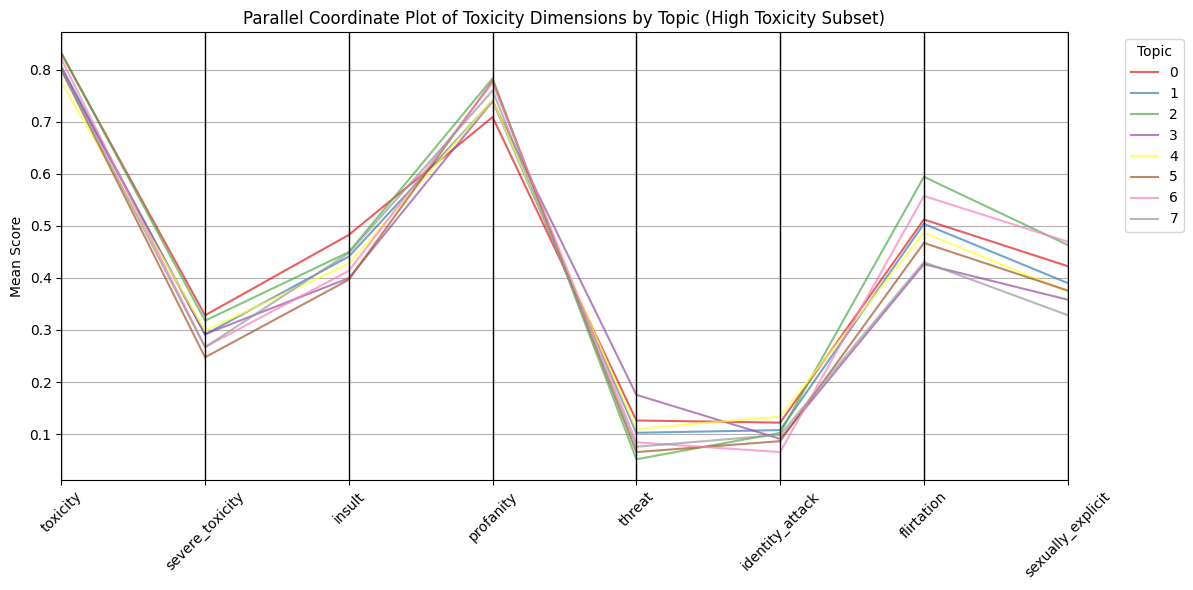

In [ ]:
#parallel coordinate plot 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

attributes = [
    "toxicity",
    "severe_toxicity",
    "insult",
    "profanity",
    "threat",
    "identity_attack",
    "flirtation",
    "sexually_explicit"
]

# calculate mean attribute scores for each dominant topic in the high subset
topic_means = high_df.groupby("dominant_topic")[attributes].mean().reset_index()

#make topics categorical for plotting
topic_means["dominant_topic"] = topic_means["dominant_topic"].astype(str)

#parallel coordinate plot
plt.figure(figsize=(12,6))
parallel_coordinates(topic_means, "dominant_topic", colormap=plt.cm.Set1, alpha=0.7)
plt.title("Parallel Coordinate Plot of Toxicity Dimensions by Topic (High Toxicity Subset)")
plt.ylabel("Mean Score")
plt.xticks(rotation=45)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Supervised Machine Learning

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

#load dataset 
df = pd.read_csv("perscoredclean.csv")

In [ ]:
#Label data
#defining toxic vs non toxic threshold
threshold = 0.7
df["label"] = (df["toxicity"] >= threshold).astype(int)

#TF-IDF vectorisation
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.8)
X = vectorizer.fit_transform(df["cleaned_body"])
y = df["label"]

#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#logistic regression for theory test
logreg = LogisticRegression(max_iter=200, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.986     0.992     0.989      1011
           1      0.619     0.481     0.542        27

    accuracy                          0.979      1038
   macro avg      0.803     0.737     0.765      1038
weighted avg      0.977     0.979     0.978      1038



In [ ]:
#top predictive features
feature_names = np.array(vectorizer.get_feature_names_out())
coef = log_reg.coef_[0]
top_positive = feature_names[np.argsort(coef)][-20:]
top_negative = feature_names[np.argsort(coef)][:20]

print("\ntoxic predictors\n", top_positive)
print("\nnontoxic predictors\n", top_negative)

In [ ]:
#cross community generalisation
#train on one subreddit, test on another
communities = df["subreddit"].unique()

for i, train_sub in enumerate(communities):
    for test_sub in communities:
        if train_sub == test_sub:
            continue
        train_mask = df["subreddit"] == train_sub
        test_mask = df["subreddit"] == test_sub

        X_train_sub = vectorizer.fit_transform(df.loc[train_mask, "cleaned_body"])
        y_train_sub = df.loc[train_mask, "label"]
        X_test_sub = vectorizer.transform(df.loc[test_mask, "cleaned_body"])
        y_test_sub = df.loc[test_mask, "label"]

        log_reg_sub = LogisticRegression(max_iter=200, class_weight='balanced')
        log_reg_sub.fit(X_train_sub, y_train_sub)
        y_pred_sub = log_reg_sub.predict(X_test_sub)

        print(f"\ntrain {train_sub} test {test_sub}")
        print(classification_report(y_test_sub, y_pred_sub, digits=3))


In [ ]:
#random Forest for Feature Importance
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

top_idx = np.argsort(importances)[-20:]
print("\nTop features\n", feature_names[top_idx])


Top features by Random Forest importance:
 ['your' 'its' 'this' 'holy' 'both' 'they' 'her' 'balls' 'you' 'it' 'the'
 'and' 'holy shit' 'is' 'my' 'the fuck' 'ass' 'fucking' 'shit' 'fuck']


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?utm_source=chatgpt.com

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html?utm_source=chatgpt.com

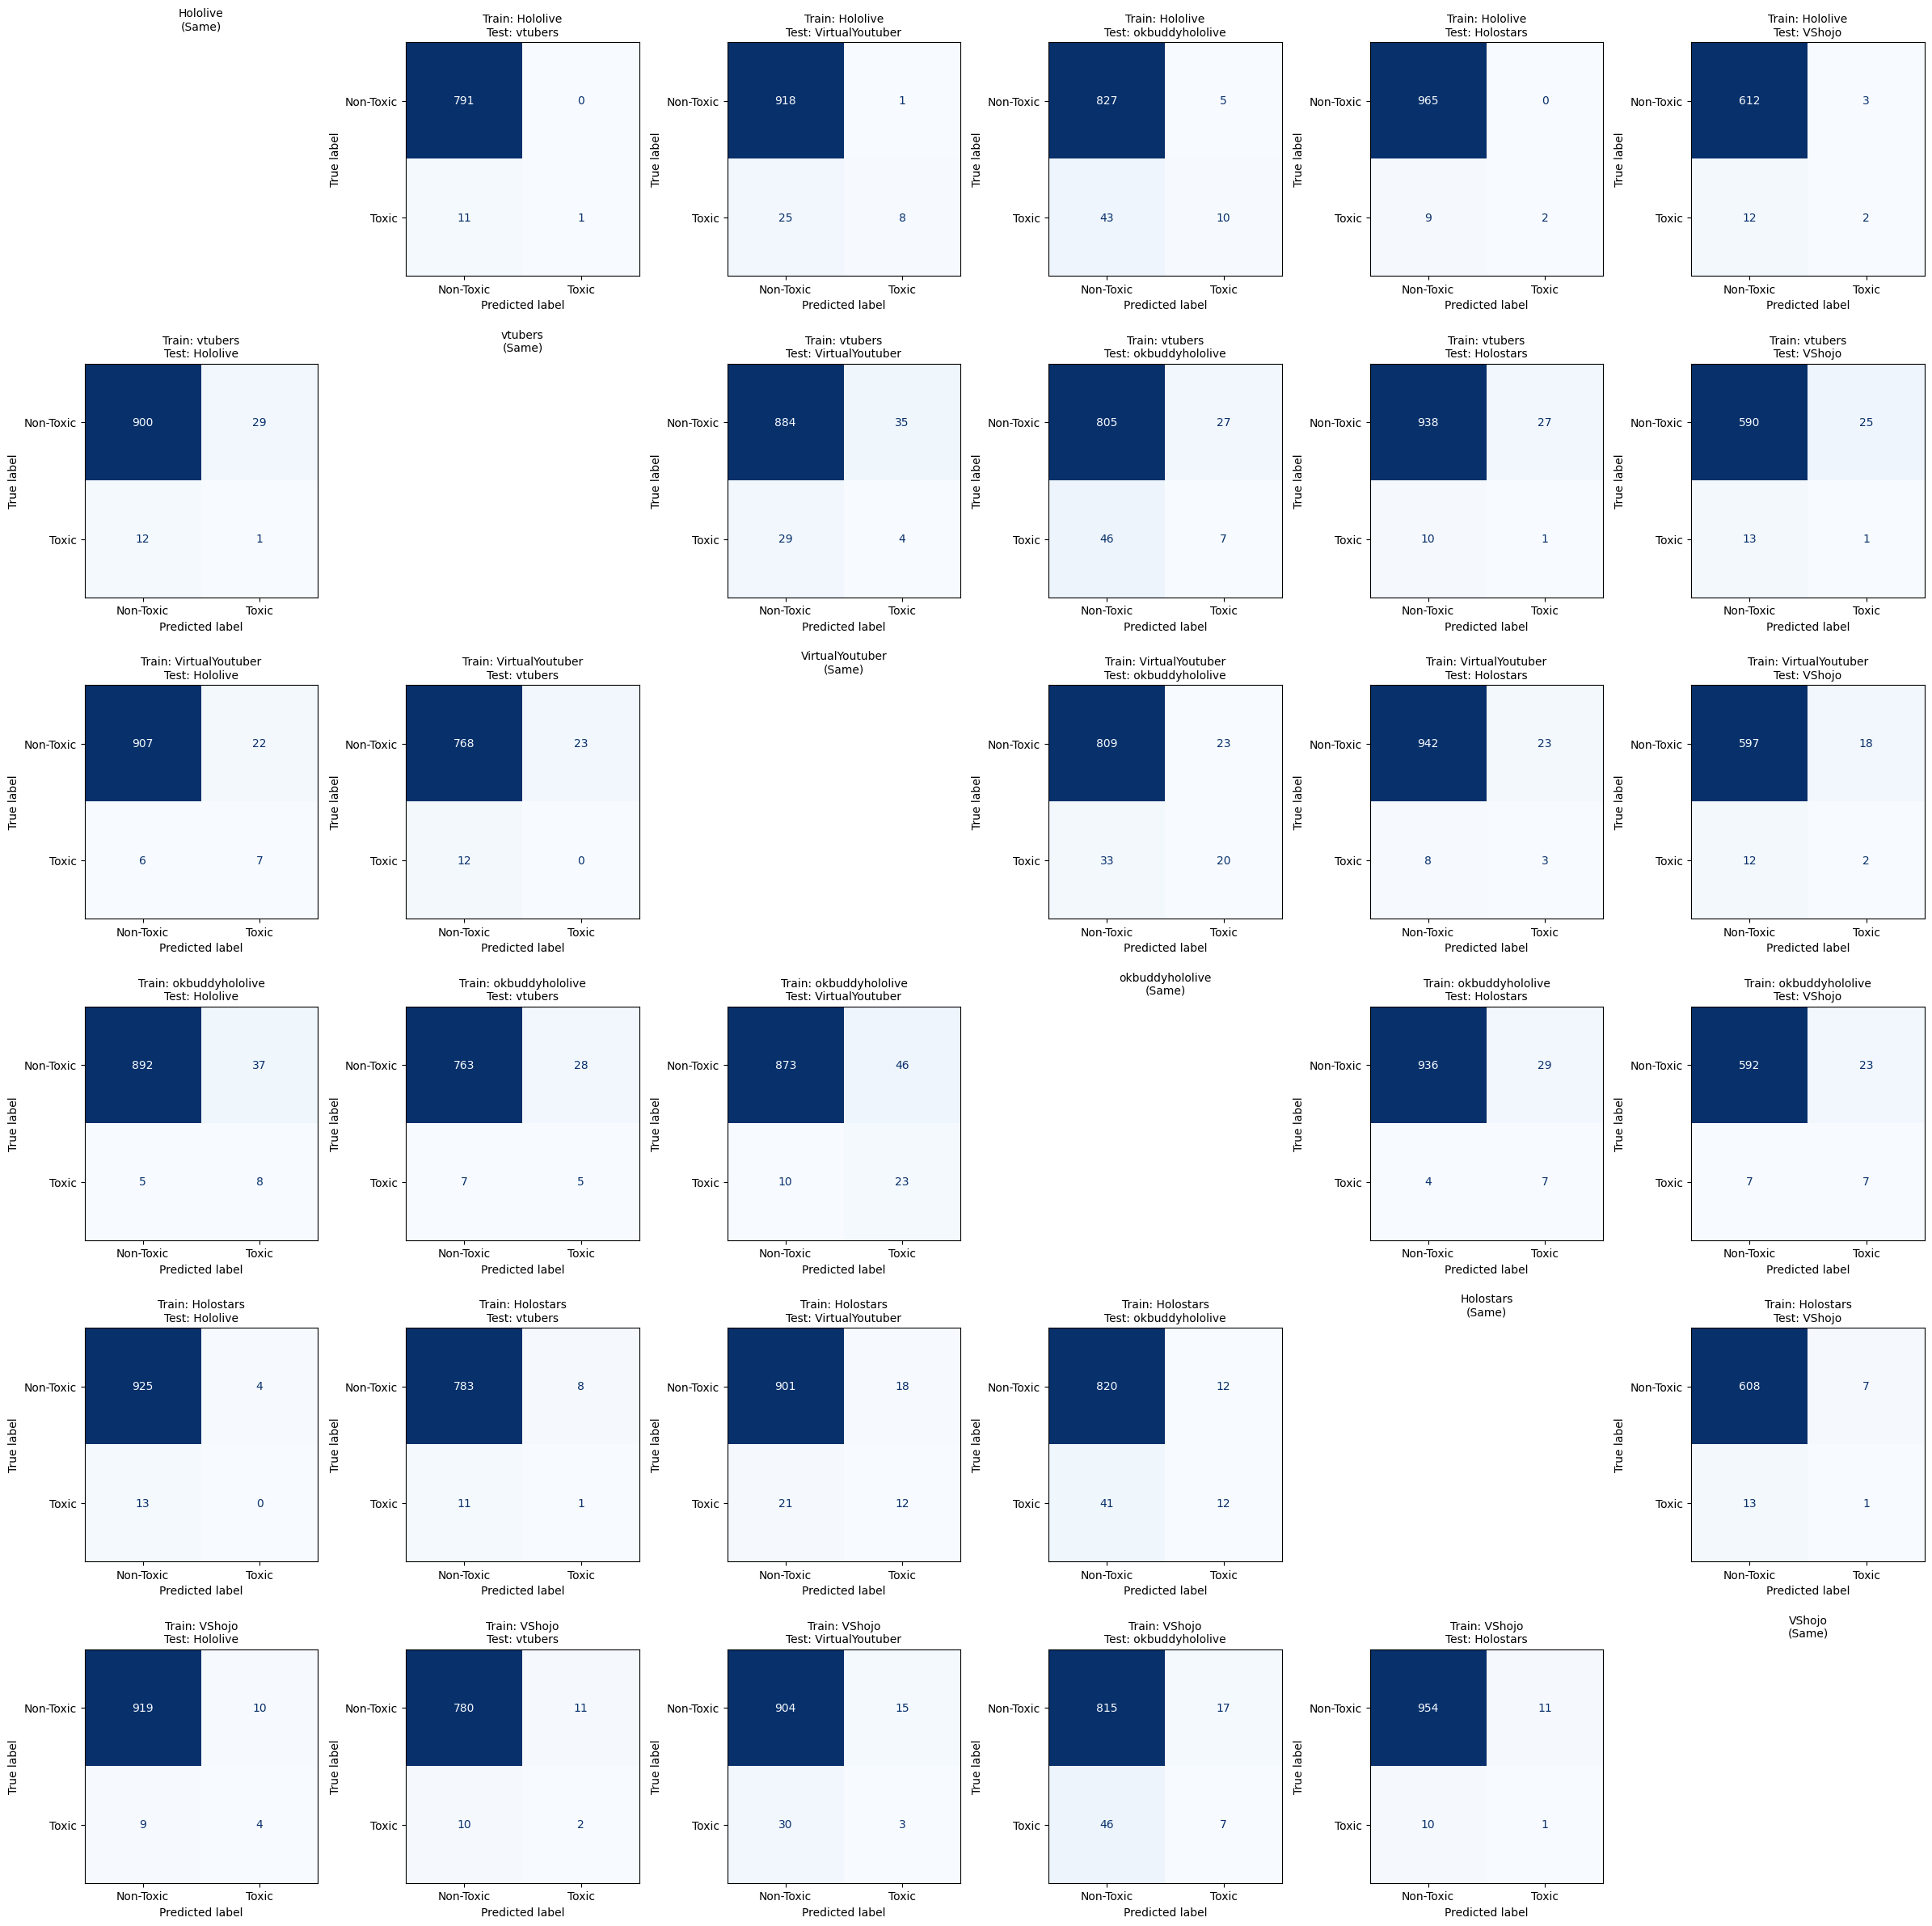

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

communities = df["subreddit"].unique()
n = len(communities)

#subplot grid, so no same-train/test)
fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(4*n, 4*n))

#loop through all combinations of train-test communities
for i, train_sub in enumerate(communities):
    for j, test_sub in enumerate(communities):
        ax = axes[i, j]  #access subplot by row and column

        if i == j:
            #leave diagonal cells blank so no same train/test
            ax.axis("off")
            ax.set_title(f"{train_sub}\n(Same)", fontsize=10)
            continue

        #train-test split
        train_mask = df["subreddit"] == train_sub
        test_mask = df["subreddit"] == test_sub

        X_train_sub = vectorizer.fit_transform(df.loc[train_mask, "cleaned_body"])
        y_train_sub = df.loc[train_mask, "label"]
        X_test_sub = vectorizer.transform(df.loc[test_mask, "cleaned_body"])
        y_test_sub = df.loc[test_mask, "label"]

        log_reg_sub = LogisticRegression(max_iter=200, class_weight="balanced")
        log_reg_sub.fit(X_train_sub, y_train_sub)
        y_pred_sub = log_reg_sub.predict(X_test_sub)

        #confusion matrix
        cm = confusion_matrix(y_test_sub, y_pred_sub)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["Non-Toxic", "Toxic"])
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.set_title(f"Train {train_sub}\nTest {test_sub}", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
##running through all potential supervised models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score

#define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced"),
    "SVM": LinearSVC(class_weight="balanced")
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #store results
    report = classification_report(y_test, y_pred, output_dict=True)
    
    #ROC-AUC
    try:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:,1]
        else:
            y_scores = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_scores)
    except:
        auc = None
    
    results[name] = {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"],
        "auc": auc
    }

import pandas as pd
df_results = pd.DataFrame(results).T
print(df_results)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                     precision    recall        f1       auc
Logistic Regression   0.976683  0.978805  0.977512  0.828186
Naive Bayes           0.948653  0.973988  0.961154  0.551965
Random Forest         0.967803  0.974952  0.965079  0.809320
SVM                   0.973755  0.976879  0.974914  0.796095


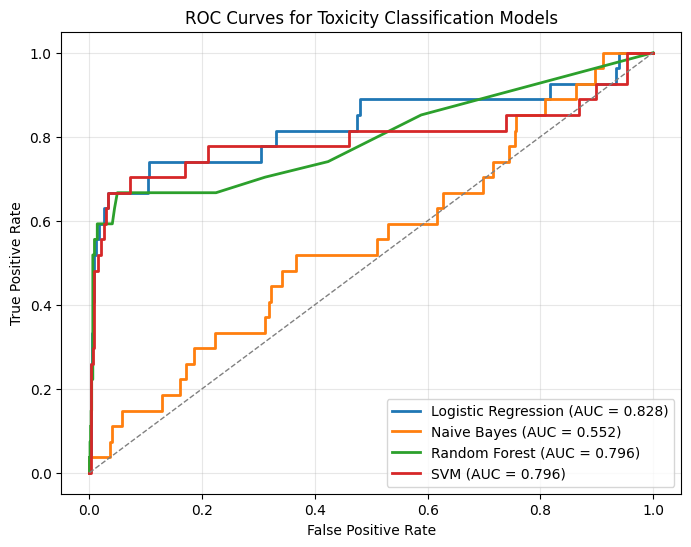

In [ ]:
##plotting visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

#models, the SVM wrapped for probabilities
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced"),
    "SVM": CalibratedClassifierCV(LinearSVC(class_weight="balanced", max_iter=5000))
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X_train, y_train)

    #get prediction scores for ROC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

#random baseline
plt.plot([0,1], [0,1], linestyle="--", color="gray", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Toxicity Classification Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()